# 1、简介

目标检测是计算机视觉的一个重要研究领域，其中boundingbox的回归是非常重要的步骤，指导网络如何优化网络中的参数使得bbox和gt更接近的就是loss函数，通过损失函数可以得到预测结果与真实值的差距。选择合适的loss能大大加速网络收敛，提高网络性能。

本文将介绍一些常用的loss的原理及其代码实现。

# 2、Smooth L1 loss
在介绍SmoothL1之前，先简单介绍一下L1 loss和L2 loss。

## 2.1、L1 loss
L1 loss 又被称为平均绝对误差（Mean Absolute Error,MAE）,计算公式为

![](https://ai-studio-static-online.cdn.bcebos.com/50dcb2b529f2499e9f274b3f0d3db1fe8016fdcd198246838d722ab9344308bb)

含义是所有预测值与对应真实值差值的绝对值的平均

## 2.2、L2 loss
L2 loss 又被称为均方误差（Mean Squared Error,MSE），计算公式为

![](https://ai-studio-static-online.cdn.bcebos.com/8a293498a10a4435ac04304ff7f0cc7291b6b91c94ba40cb8373f8d0724819f7)

含义是所有预测值与对应真实值差值的平方的平均


公式中，fx为预测值，y为真实标签。两种loss各有优劣，L1 loss的鲁棒性更强，但其梯度
更新始终相同，在预测值与真实值相近时，仍有相对较大的梯度，不利于模型的训练，同时L1 Loss中在0点处导数不存在，会导致一些计算上的麻烦。L2 loss利于训练，但对于异常的值有较差的鲁棒性，当存在偏差较大的错误标签时，L2 loss会集中于该错误值。

## 2.3、Smooth L1 loss
Smooth L1 loss较好地解决了上述问题，其公式如下

![](https://ai-studio-static-online.cdn.bcebos.com/0123ac14061244658d19a88b41a0ab1a64e879d752fe42d3916f8a6c61ac7146)
其中
![](https://ai-studio-static-online.cdn.bcebos.com/c11fc8f0c45d418e814b3d5a9c884edc72f5b223f0674b2b8457d43594835da1)

Smooth L1 Loss 综合了两者的优点，在x小于1时，使用二次方可以有效的减少梯度，而值较大时，线性差值也能保持梯度稳定。是比较常用的一种loss



In [2]:
# 三种loss的简单测试
import paddle
import numpy as np
import paddle.nn.functional as F

x = np.random.rand(10,10)
y = np.random.rand(10,10)

x = paddle.to_tensor(x)
y = paddle.to_tensor(y)

L1loss = F.l1_loss(x,y)
L2loss = F.mse_loss(x,y)
SmoothL1loss = F.smooth_l1_loss(x,y)

print('L1loss:',L1loss)
print('L2loss:',L2loss)
print('Smoothloss:',SmoothL1loss)

L1loss: Tensor(shape=[1], dtype=float64, place=CPUPlace, stop_gradient=True,
       [0.36585948])
L2loss: Tensor(shape=[1], dtype=float64, place=CPUPlace, stop_gradient=True,
       [0.18218531])
Smoothloss: Tensor(shape=[1], dtype=float64, place=CPUPlace, stop_gradient=True,
       [0.09109265])


# 3、IoU
## 3.1、 概念
交并比（Intersection over Union,IoU）是目标检测中最常用的评估指标

![](https://ai-studio-static-online.cdn.bcebos.com/b1b4a69daea34e3b8d3b1abf91f2743959f578f487fa409a80ebc252d4e28129)

![](https://ai-studio-static-online.cdn.bcebos.com/0a7a3ba85aca473d9d25e18df4fbb2789fc55c51d4b3408fb50c78a99580d9f5)

如图，IoU的计算公式为：

![](https://ai-studio-static-online.cdn.bcebos.com/dda50f9f9d3e45419183735dffefc91168131d1bf2d34f148391929f4c5766ce)

其中，A和B分别为预测框和GroundTruth。显然，IoU的值越高也说明A框与B框重合程度越高，代表模型预测越准确。反之，IOU越低模型性能越差。

## 3.2、优缺点
IoU的优缺点都很明显，优点如具有尺度不变性，简单易用等。缺点是IoU没有考虑到距离信息，当两个框没有交集时，IoU的值为0，梯度为0,无法进行回归。而且IoU不能反映两框之间的距离，如下图所示：

![](https://ai-studio-static-online.cdn.bcebos.com/e299308705a24bd6aca3fe219f18358593394b05d80245a992117230ff0323c3)

![](https://ai-studio-static-online.cdn.bcebos.com/3fd740aaa60b4b839285e4bf9a295d7b701dedc81b294261a9b5301a9c02c0fb)


显然第二张图片的检测框要更偏离GT，但两者的IoU均为0

此外，IoU仅考虑重复的面积大小，对于检测框的相交方式并不关心。


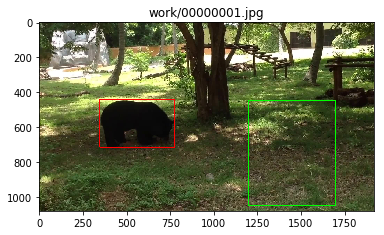

IoU: 0.0000


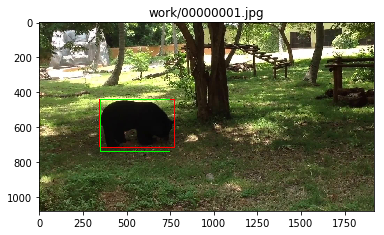

IoU: 0.8507


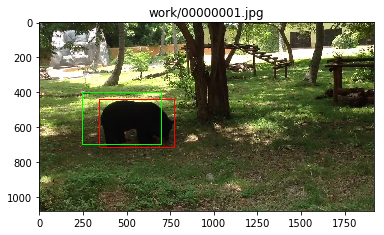

IoU: 0.5636


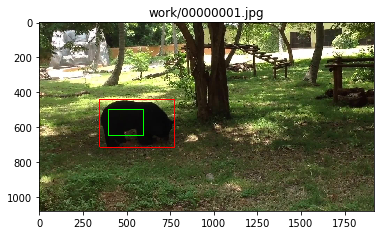

IoU: 0.2571


In [9]:
import cv2
import math 
import matplotlib.pyplot as plt 
import numpy as np
import paddle
 
def draw_rect(img,box,color):   # 画box
    pt1 = (int(box[0]), int(box[1]))
    pt2 = (int(box[0] + box[2]), int(box[1] + box[3]))
    img = cv2.rectangle(img, pt1, pt2, color, thickness=3)
    return img

def show(img_path,bbox):
    cbox = [min(bbox[0],gt[0]),                  
        min(bbox[1],gt[1]),
        max(bbox[0]+bbox[2],gt[0]+gt[2])-min(bbox[0],gt[0]),
        max(bbox[1]+bbox[3],gt[1]+gt[3])-min(bbox[1],gt[1])]
    plt.title(img_path)
    img = cv2.imread(img_path)
    img = draw_rect(img,gt,(0,0,255))
    img = draw_rect(img,bbox,(0,255,0))
    img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img1)
    plt.show()


# ltwh转成xxyy
def convertltwh2xxyy(box): 
    x1= box[0]
    x2= box[0] + box[2]
    y1= box[1]
    y2= box[1] + box[3]
    return x1,x2,y1,y2


def computeIoU(box1,box2, GIoU=False, DIoU=False, CIoU=False, xxyy=False): # box1:gt,box2:预测
    if xxyy:
        b1x1,b1x2,b1y1,b1y2=box1[0],box1[1],box1[2],box1[3]
        b2x1,b2x2,b2y1,b2y2=box2[0],box2[1],box2[2],box2[3]
    else: 
        b1x1,b1x2,b1y1,b1y2 = convertltwh2xxyy(box1)
        b2x1,b2x2,b2y1,b2y2 = convertltwh2xxyy(box2)

    inter = (min(b1x2,b2x2)-max(b1x1,b2x1)) * (min(b1y2,b2y2)-max(b1y1,b2y1))  #求交集
    if inter < 0 : 
        inter = 0
    w1,h1 = b1x2-b1x1,b1y2-b1y1
    w2,h2 = b2x2-b2x1,b2y2-b2y1
    union = w1*h1 + w2*h2 - inter   # 求并集
    iou = inter/union


    if CIoU or DIoU or GIoU:
        w_c = max(b1x2,b2x2)-min(b1x1,b2x1)  #最小矩形的长宽
        h_c = max(b1y2,b2y2)-min(b1y1,b2y1) 
        if CIoU or DIoU:
           c_2 = w_c**2 +h_c**2  # 对角线的平方
           rho2 =  (((b1x1+b1x2)/2)-((b2x2+b2x1)/2))**2+(((b1y1+b1y2)/2)-((b2y2+b2y1)/2))**2 #中心点距离
           if CIoU:
               v = (4/math.pi**2)*(math.atan(w1/h1) - math.atan(w2/h2))**2   #长宽比信息
               with paddle.no_grad():
                   alpha = v / (1-iou+v)
               return iou - rho2 / c_2 - v * alpha # CIoU
           return iou-rho2/c_2 #DIoU
        area_c = w_c * h_c
        return iou - ((area_c - union)/area_c) #GIoU
    return iou
if __name__ == '__main__':
    img_path = 'work/00000001.jpg'
    label_path = 'work/groundtruth.txt'
    gt =  np.loadtxt(label_path,delimiter=',')   #[l,t,w,h]
    bbox_list = [[1200,450,500,600],[350,440,400,300],[250,400,450,300],[400,500,200,150]]

    for i in range(len(bbox_list)):   
        bbox = bbox_list[i]
        show(img_path,bbox)
        print("IoU:",format(computeIoU(gt,bbox),'.4f'))

# 4、GIoU


论文地址：[Generalized Intersection over Union: A Metric and A Loss for Bounding Box Regression](https://arxiv.org/abs/1902.09630)

## 4.1、原理
针对IoU的各种缺陷，这篇paper提出了一个新的IoU计算方式，该方法考虑到了检测框之间的位置信息，比IoU更加完善。


![](https://ai-studio-static-online.cdn.bcebos.com/7b6d6c29bcd04a92b6db10b2b151c000553eb093d422437db0d9171b893d8349)

## 4.2、公式
该方法总共可以分成三步：

1、找出同时包含两个检测框的最小矩形C，即图中的蓝色框

2、计算IoU和C的面积

3、计算GIoU，公式为：

![](https://ai-studio-static-online.cdn.bcebos.com/eff0555151de4d5b90ed68bc6cf3a76ab8d95ec170d04c0fa5e1417a66bb8f24)

当IoU为0时，A与B距离越远，C越大，则GIoU趋近于-1，当IoU为1时，两框重合，此时GIoU也为1。
特别的，当一个框被另一个框完全包裹时，GIoU将退化为IoU






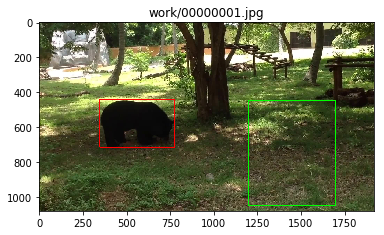

GIoU: -0.492630


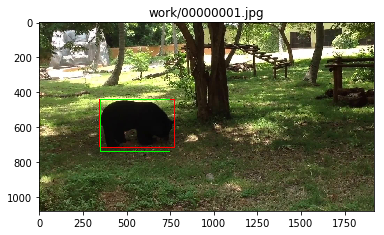

GIoU: 0.844435


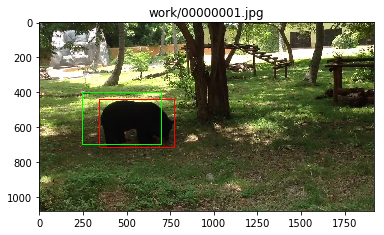

GIoU: 0.535095


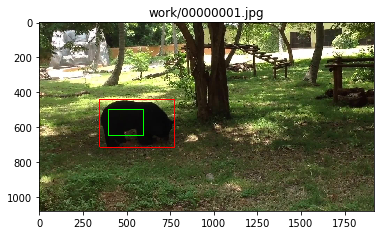

GIoU: 0.257096


In [10]:

    for i in range(len(bbox_list)):   
        bbox = bbox_list[i]
        show(img_path,bbox)
        print("GIoU:",format(computeIoU(gt,bbox,GIoU=True),'.6f'))

# 5、DIoU和CIoU

论文地址：[Distance-IoU Loss: Faster and Better Learning for Bounding Box Regression](https://arxiv.org/abs/1911.08287)

## 5.1、原理
论文指出，在实际训练的过程中使用GIoU时检测框会先放大，使得检测框与GT有重叠；而DIoU可以直接减少两框中心点之间的距离。

![](https://ai-studio-static-online.cdn.bcebos.com/37b4ef0671084711922efeb62476884d7a3321031d44431fa5ded52ae4001ddc)

基于上，作者提出了2个问题，第一：最小化两个边界框中心点的归一化距离能否加快收敛。第二：如何在回归时，能够更好的描述重叠信息，同时使得回归更准确，更快速？

## 5.2、DIoU公式
针对第一个问题，作者提出了DIoU（Distance-IoU），公式如下：

![](https://ai-studio-static-online.cdn.bcebos.com/e54a0e281a854610b54dfa51f8d8a71263422c30c2ca4da784ce18dfa5e1524f)
![](https://ai-studio-static-online.cdn.bcebos.com/5a91771938e745acb2b6cf325749e29745588b9c6038438ca192f68260735c94)


式中，a和b为两框的中心点坐标，ρ（）为两点的欧式距离，c为包含两框的最小矩形的对角线长度

![](https://ai-studio-static-online.cdn.bcebos.com/da3d2873b4fd42f7918bdcb6ab8c5f2a3ae9247dbfd5489085b59a84d20ef97a)

DIoU的优点是收敛快，当出现包含的情况时，DIoU可以很快地回归，而此时GIoU已经退化为了IoU

## 5.3、CIoU公式
针对第二个问题，作者又提出了CIoU（Complete IoU）,paper中指出，回归预测的bbox有三个重要因素，重叠面积，中心点距离和长宽比。因此，作者在DIoU的基础上，引入了长宽比的信息，该方法称为CIoU，公式如下：

![](https://ai-studio-static-online.cdn.bcebos.com/9575ab0efaa646c783e5ec72c4c846bd395aeedc0970447d96ea0da63fa78389)

![](https://ai-studio-static-online.cdn.bcebos.com/4cf213833a6646ba95291e0f7160ddf71e5a43ee694e479493a35a08e0647be6)

![](https://ai-studio-static-online.cdn.bcebos.com/43f2f3db03ed49b688a95db9f171d3047157d65298214ef3ab369f3d8bc68b62)

式中，a为GT，b为预测框，alpha为平衡比例的系数，v是描述长宽比一致性的参数

![](https://ai-studio-static-online.cdn.bcebos.com/48eb1987d84545c2958f62ed55c5ea8cf4eb6a70918b42ab97ddfcbfa2bad18d)

在梯度计算的过程中，由于w^2+h^2一般较小，会导致梯度爆炸，因此为了稳定地收敛，将w^2+h^2用1代替






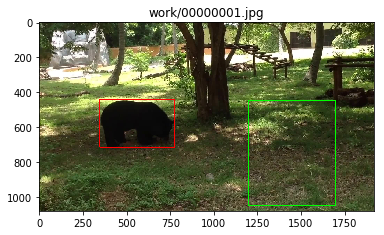

DIoU: -0.372284
CIoU: -0.373762


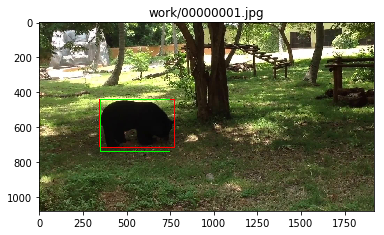

DIoU: 0.849820
CIoU: 0.849779


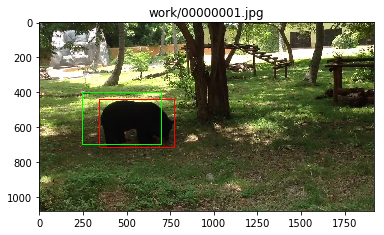

DIoU: 0.541458
CIoU: 0.541458


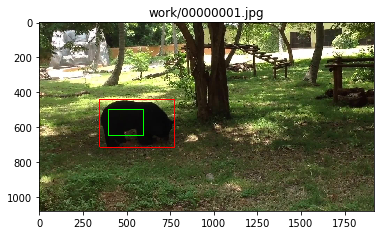

DIoU: 0.242375
CIoU: 0.242367


In [11]:
    for i in range(len(bbox_list)):   
        bbox = bbox_list[i]
        show(img_path,bbox)
        print("DIoU:",format(computeIoU(gt,bbox,DIoU=True),'.6f'))
        print("CIoU:",format(computeIoU(gt,bbox,CIoU=True),'.6f'))

# 6、IoU-Aware
论文地址：[IoU-aware Single-stage Object Detector for Accurate Localization
](http://arxiv.org/abs/1912.05992)

![](https://ai-studio-static-online.cdn.bcebos.com/3dbe54730e4b48f28562bbc1f4e17a0d36fb7f6c88a84042bcffd1c77eac39f7)

## 6.1、原理
在这篇paper中，作者认为目前的单阶段检测的准确率不如两阶段的一个原因是分类分数和回归分数相关性差。由此引出两个问题：
1、NMS时，只能使用分类置信度来进行anchor排序，导致高IoU但低分类分数的anchor被过滤。
2、计算AP时，依然是使用分类置信度进行排序计算的，高分类置信度但低IoU的anchor会降低高IoU阈值时的AP。

因此，作者在原本的回归分支添加了一个head，用于预测iou，预测的iou与回归分支和分类分支一起训练。另一种方式是直接添加一个iou分支，仅用于预测iou，但填加分支会大大增加计算成本，因此选择在回归分支添加。而在推理时，anchor的分数将由分类置信度和预测iou共同决定。

## 6.2、公式

![](https://ai-studio-static-online.cdn.bcebos.com/74edf109904f4db1a5e85e4df6f6a493db25ab34cc6e436584790149b01b4855)

式中，Npos是正样本的个数，CE（）是求交叉熵，![](https://ai-studio-static-online.cdn.bcebos.com/bd748a5769c54a3f8c1bb101cf89cd7f5c9f509d15404a608955c6e71374013a)是head预测的IoU值，而
![](https://ai-studio-static-online.cdn.bcebos.com/e613c7b16d574fd1b75faa09a921b22f0f5b4a62522c49b5a118b5dff9da9377)是实际预测框和GT的IoU，这里的IoU可以使用原始的IoU公式计算，也可以使用上面的GIoU，DIoU，CIoU等

最终，预测的置信度将由下式计算：
![](https://ai-studio-static-online.cdn.bcebos.com/db7e23508db74afdb667cef4f7e34cc586671c43c2e9456eb91e8a820ccfbc03)
其中，p为分类的置信度，alpha为控制两者权重的参数，在实际中，也可以直接将p和IoU相乘作为结果，能得到基本相同的效果。




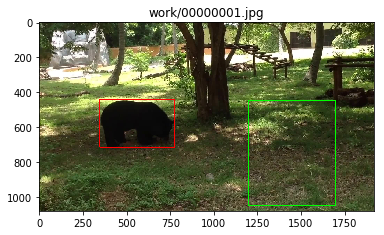

IoUawareloss: Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=True,
       [1.17110062])


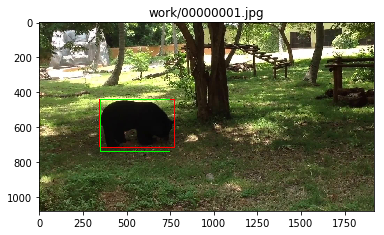

IoUawareloss: Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=True,
       [0.49050504])


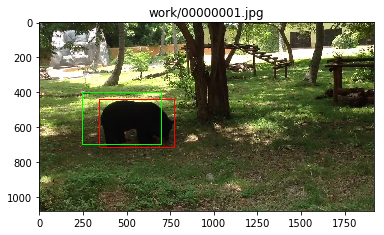

IoUawareloss: Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=True,
       [0.72022057])


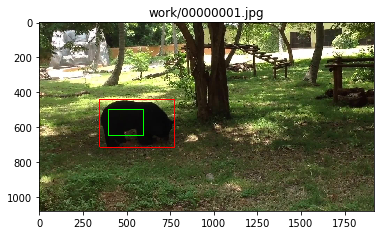

IoUawareloss: Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=True,
       [0.96542394])


In [12]:
# pred_iou是head输出的预测值
def iou_aware(pred_iou,gt,box, GIoU=False, DIoU=False, CIoU=False):
    iou = computeIoU(gt,box, GIoU=False, DIoU=False, CIoU=False)
    iou=paddle.to_tensor(iou)
    pred_iou=paddle.to_tensor(pred_iou)
    with paddle.no_grad():
        loss=F.binary_cross_entropy_with_logits(pred_iou,iou)
    return loss 

for i in range(len(bbox_list)):
        p = 0.8   # 预测iou值 
        bbox = bbox_list[i]
        show(img_path,bbox)
        print("IoUawareloss:",iou_aware(p,gt,bbox))

# 7、总结

目前，目标检测领域的Loss函数种类很多，迭代的顺序为IoU-GIoU-DIoU-CIoU，上面的方法都能在一定程度上提高模型的性能。


## 作者简介
> 作者：yuukiyuuki

> paddle初学者，coding水平有待提高，研究方向是目标跟踪和边缘计算，搬砖中。。。

> 我在AI Studio上获得白银等级，点亮2个徽章，来互关呀~https://aistudio.baidu.com/aistudio/personalcenter/thirdview/801662
